      Open     High      Low    Close    Volume  OpenInt
0  0.42388  0.42902  0.41874  0.42388  23220030        0
1  0.42388  0.42516  0.41366  0.42134  18022532        0
2  0.42516  0.43668  0.42516  0.42902  42498199        0
3  0.42902  0.43157  0.41618  0.41618  37125801        0
4  0.43927  0.44052  0.43927  0.43927  57822062        0


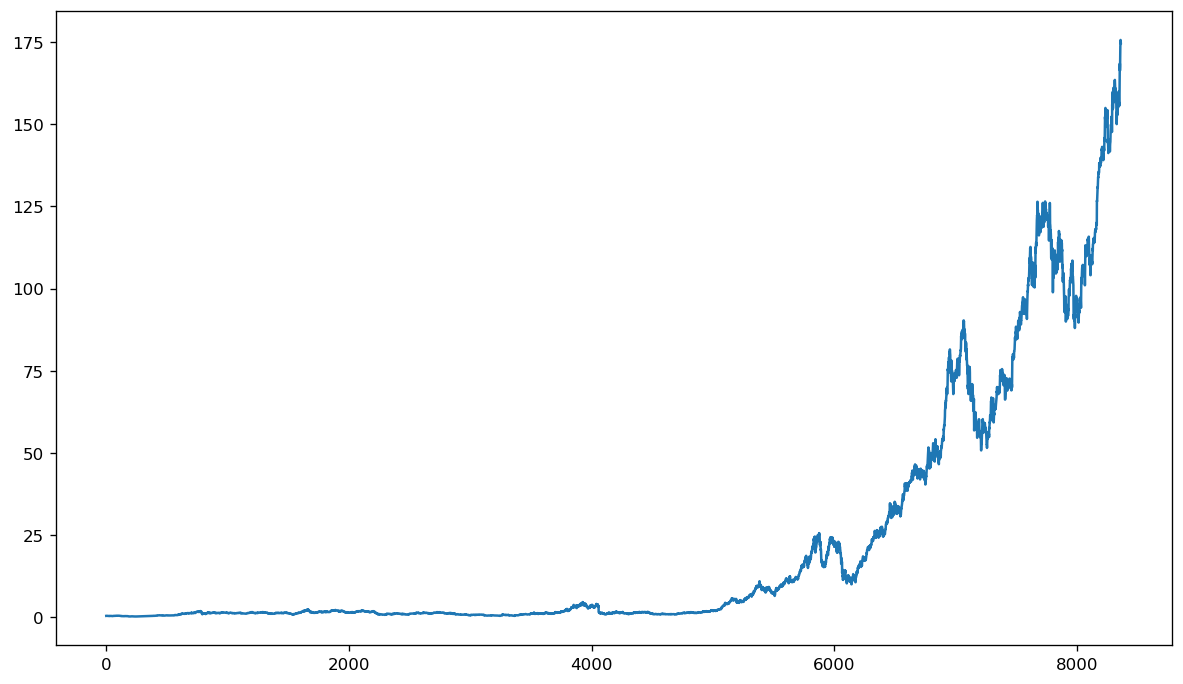

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.figsize':(12,7), 'figure.dpi':120})

df = pd.read_csv('../data_preprocess_v3/aapl.us.csv', header=0, index_col=0)
df.index = [i for i in range(len(df.index))]
print(df.head())
plt.plot(df.index, df['Close'])
plt.show()

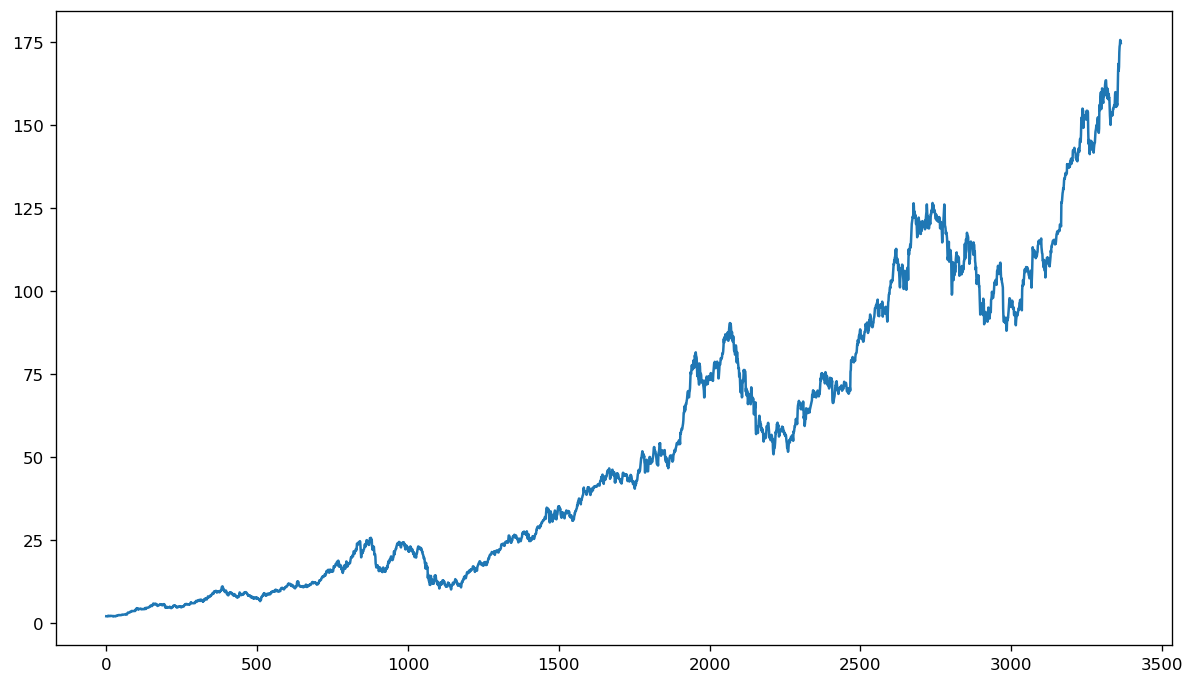

In [6]:
df = df[df.index >= 5000]
df.index = [i for i in range(len(df.index))]
plt.plot(df.index, df['Close'])
plt.show()

In [7]:
df = df[['Close', 'Volume']]
df.head()

,Close,Volume
0,1.9465,110991701
1,1.9301,65085083
2,1.9236,58246879
3,1.8658,142681355
4,1.8708,88175232


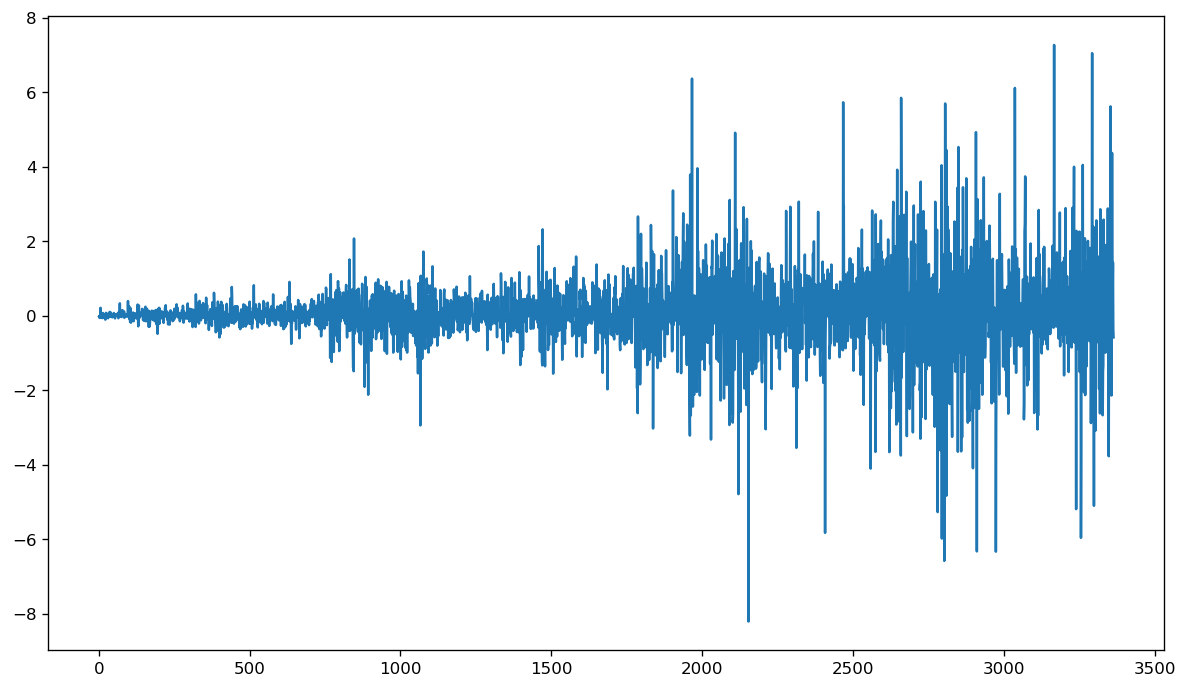

In [8]:
df2 = df['Close'].diff().dropna()

df2.head()
df2.plot()
plt.show()

      Close     Volume
1 -0.849697   65085083
2 -0.337908   58246879
3 -3.097867  142681355
4  0.267265   88175232
5  1.230136  233280438
         Close    Volume
3359  1.007890  34901241
3360  0.315765  24424877
3361  0.814304  24451166
3362 -0.205421  29533086
3363 -0.332055  25130494


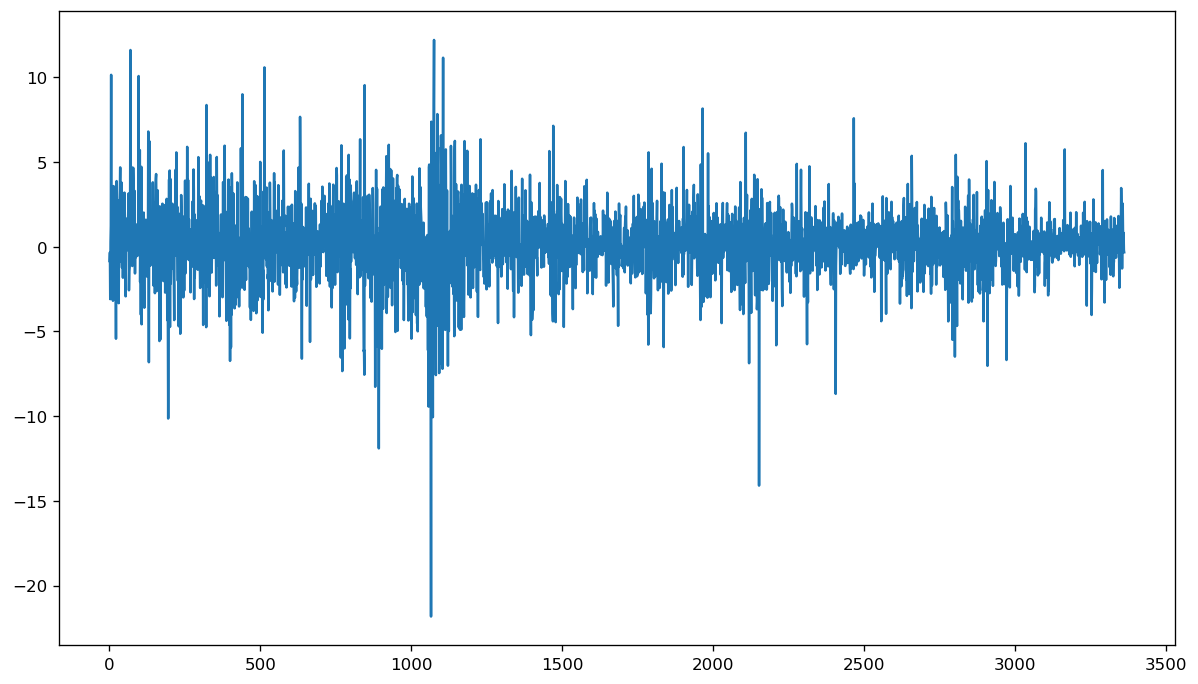

In [9]:
close_diff = df['Close'].diff().dropna()
close_diff_p = (close_diff / df['Close']) * 100
close_diff_p = close_diff_p[1:]

close_diff_p = pd.DataFrame(close_diff_p)
close_diff_p['Volume'] = df['Volume']
print(close_diff_p.head())
print(close_diff_p.tail())
plt.plot(close_diff_p.index, close_diff_p['Close'])
plt.show()

In [10]:
def generate_data(df, col, lag):
    new_df = df.loc[:]
    for i in range(1,lag+1):
        col_name = col + '-' + str(i)
        new_df[col_name] = df[col].shift(-i)
        
    return new_df

In [11]:
from sklearn import metrics 
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns

def split_and_train(df, test, c, random, threshold, solver):
    X = df.drop(['Volume','Close', 'label'], axis=1)
    y = df['label']
    
    # Split the dataset into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test, random_state=random)

    plt.plot(df[(int)(len(df)*(1-test)):], 'green', label='Train data')
    plt.plot(df[:(int)(len(df)*(1-test))], 'blue', label='Test data')
    plt.show()
    
    # Train the model
    model = LogisticRegression(C=c, solver=solver)
    model.fit(X_train, y_train)
    
    print('The learned weights are {} {}'.format(model.intercept_, model.coef_)) 

    preds = model.predict_proba(X_train) # Predict on our training set.
    print('The classification accuracy for train set: {}'.format((((preds[:,1] > threshold) == y_train).mean())))

    preds = model.predict_proba(X_test) # Predict on our test set.
    print('The classification accuracy for test set: {}'.format((((preds[:,1] > threshold) == y_test).mean())))
    
    return model, y_test.to_numpy(), preds[:,1]

def show_roc(label, prob):
    plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
    # calculate roc curve for model
    fpr, tpr, _ = roc_curve(label, prob)
    # plot model roc curve
    plt.plot(fpr, tpr, marker='.', label='Logistic')
    # calculate roc auc
    roc_auc = roc_auc_score(label, prob)
    plt.title('ROC AUC Curve')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    print('ROC AUC : %.3f' % roc_auc)


def show_pr(label, prob):
    # plot no skill precision-recall curve
    no_skill = len(label[label==1]) / len(label)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    # calculate precision-recall curve for model
    precision, recall, _ = precision_recall_curve(label, prob, pos_label=1)
    # plot model precision-recall curve
    plt.plot(recall, precision, marker='.', label='Logistic')
    plt.title('PR AUC Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()
    # calculate roc auc
    auc_score = auc(recall, precision)
    print('PR AUC : %.3f' % auc_score)
    
def show_cm(label, prob, threshold, names): # Confusion Matrix
    cnf_matrix = metrics.confusion_matrix(label, prob > threshold)
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names)
    plt.yticks(tick_marks, names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.xlabel('Actual label')
    plt.ylabel('Predicted label')
    plt.show()
    
def show_f1(label, prob, threshold):
    score = f1_score(label, prob > threshold)
    print('F1 Score : %.3f' % score)
    
def build(df, test, C, random, threshold, solver):
    model, label, prob = split_and_train(df, test, C, random, threshold, solver)
    show_roc(label, prob)
    show_pr(label, prob)
    show_cm(label, prob, threshold, [0, 1])
    show_f1(label, prob, threshold)

In [12]:
new_df = generate_data(close_diff_p, 'Close', 5)
new_df = new_df.dropna()
new_df['label'] = np.where(new_df['Close'] > 0, 1, 0)
new_df

,Close,Volume,Close-1,Close-2,Close-3,Close-4,Close-5,label
1,-0.849697,65085083,-0.337908,-3.097867,0.267265,1.230136,10.138533,0
2,-0.337908,58246879,-3.097867,0.267265,1.230136,10.138533,-2.231060,0
3,-3.097867,142681355,0.267265,1.230136,10.138533,-2.231060,-0.762389,0
4,0.267265,88175232,1.230136,10.138533,-2.231060,-0.762389,0.756620,1
5,1.230136,233280438,10.138533,-2.231060,-0.762389,0.756620,-1.837400,1
...,...,...,...,...,...,...,...,...
3354,2.197207,44861465,1.371490,-1.286908,0.728315,2.542471,1.007890,1
3355,1.371490,36176411,-1.286908,0.728315,2.542471,1.007890,0.315765,1
3356,-1.286908,33758685,0.728315,2.542471,1.007890,0.315765,0.814304,0
3357,0.728315,41542177,2.542471,1.007890,0.315765,0.814304,-0.205421,1


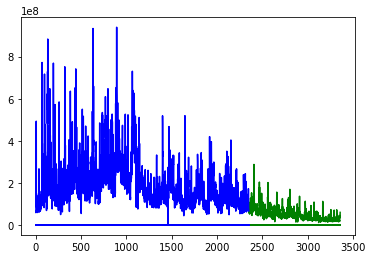

The learned weights are [0.06622085] [[ 0.03689569 -0.02342893 -0.01962529  0.02278246  0.02267233]]
The classification accuracy for train set: 0.5387234042553192
The classification accuracy for test set: 0.5466269841269841


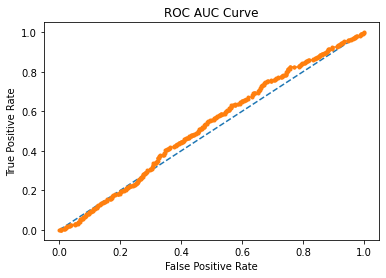

ROC AUC : 0.526


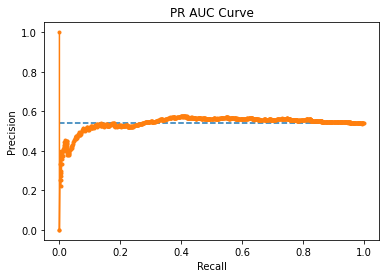

PR AUC : 0.541


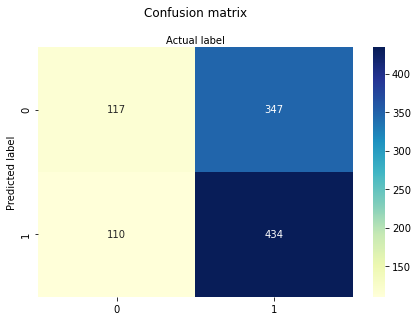

F1 Score : 0.655


In [13]:
%matplotlib inline
build(new_df, 0.3, 3e-3, 0, 0.5, 'liblinear')

In [14]:
# what if I just assume?
pred = pd.DataFrame()
pred['Prediction'] = np.where((new_df['Close'] * new_df['Close-1']) > 0, 1, 0)
print(pred)
print(len(pred['Prediction'] == 1))
print(len(pred['Prediction'] == 0))
pred['Prediction'].mean()

      Prediction
0              1
1              1
2              0
3              1
4              1
...          ...
3353           1
3354           0
3355           0
3356           1
3357           1

[3358 rows x 1 columns]
3358
3358


0.49612864800476475